In [1]:
%run nlp_core.ipynb

Shape: (120000, 2)
Num classes: 4
Labels: [0, 1, 2, 3]


In [2]:
vocab, train_loader, val_loader, test_loader = prepare_core(
    train_csv_path="data/train.csv",
    test_csv_path="data/test.csv",
    val_size=0.1,
    max_vocab=30000,
    max_len=200,
    batch_size=64,
    seed=SEED
)

print("Vocab size:", len(vocab))
x, y, lengths = next(iter(train_loader))
print("x:", x.shape, "y:", y.shape, "lengths:", lengths.shape, "labels sample:", y[:10], "lengths sample:", lengths[:10])

Vocab size: 30000
x: torch.Size([64, 200]) y: torch.Size([64]) lengths: torch.Size([64]) labels sample: tensor([0, 2, 1, 2, 3, 2, 0, 2, 1, 2]) lengths sample: tensor([39, 37, 37, 39, 45, 50, 49, 49, 41, 33])


In [3]:
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        emb = self.embedding(x)

        packed = pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, _) = self.lstm(packed)

        last_hidden = self.dropout(h_n[-1])
        return self.fc(last_hidden)

In [4]:
lstm_model = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=128,
    hidden_dim=128,
    num_classes=4,
    num_layers=1,
    dropout=0.2,
    pad_idx=vocab[PAD_TOKEN]
)

lstm_model, lstm_history = train_model(
    lstm_model,
    train_loader,
    val_loader,
    epochs=6,
    lr=1e-3,
    device=device
)

Epoch 01 | train loss 0.5233 acc 0.8057 f1 0.8051 || val loss 0.3434 acc 0.8851 f1 0.8848
Epoch 02 | train loss 0.2802 acc 0.9095 f1 0.9094 || val loss 0.3071 acc 0.9022 f1 0.9022
Epoch 03 | train loss 0.2157 acc 0.9302 f1 0.9301 || val loss 0.2773 acc 0.9132 f1 0.9129
Epoch 04 | train loss 0.1695 acc 0.9452 f1 0.9452 || val loss 0.2983 acc 0.9097 f1 0.9098
Epoch 05 | train loss 0.1296 acc 0.9577 f1 0.9577 || val loss 0.2799 acc 0.9125 f1 0.9124
Epoch 06 | train loss 0.0969 acc 0.9677 f1 0.9677 || val loss 0.3140 acc 0.9102 f1 0.9099


In [5]:
test_loss, test_acc, test_f1 = run_epoch(lstm_model, test_loader, optimizer=None, device=device)
print(f"TEST | loss {test_loss:.4f} acc {test_acc:.4f} f1 {test_f1:.4f}")

TEST | loss 0.3355 acc 0.9049 f1 0.9045


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def get_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y, lengths in loader:
            x, y, lengths = x.to(device), y.to(device), lengths.to(device)
            logits = model(x, lengths)
            preds = torch.argmax(logits, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

def plot_history(history, title_prefix=""):
    history = np.array(history, dtype=float)
    epochs = history[:, 0]
    tr_loss, tr_acc = history[:, 1], history[:, 2]
    va_loss, va_acc = history[:, 4], history[:, 5]

    plt.figure()
    plt.plot(epochs, tr_loss, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"{title_prefix} Train Loss")
    plt.show()

    plt.figure()
    plt.plot(epochs, tr_acc, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Train Accuracy")
    plt.show()

    plt.figure()
    plt.plot(epochs, va_loss, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(f"{title_prefix} Validation Loss")
    plt.show()

    plt.figure()
    plt.plot(epochs, va_acc, color="blue")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Validation Accuracy")
    plt.show()

def full_evaluation(model, history, test_loader, device, name="Model"):
    test_loss, test_acc, test_f1 = run_epoch(model, test_loader, optimizer=None, device=device)
    print(f"{name} TEST | loss {test_loss:.4f} acc {test_acc:.4f} f1 {test_f1:.4f}")

    y_true, y_pred = get_preds(model, test_loader, device)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=2))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    plt.figure()
    disp.plot(values_format="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    plot_history(history, title_prefix=name)

LSTM TEST | loss 0.3355 acc 0.9049 f1 0.9045

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1900
           1       0.95      0.97      0.96      1900
           2       0.89      0.85      0.87      1900
           3       0.88      0.89      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



<Figure size 640x480 with 0 Axes>

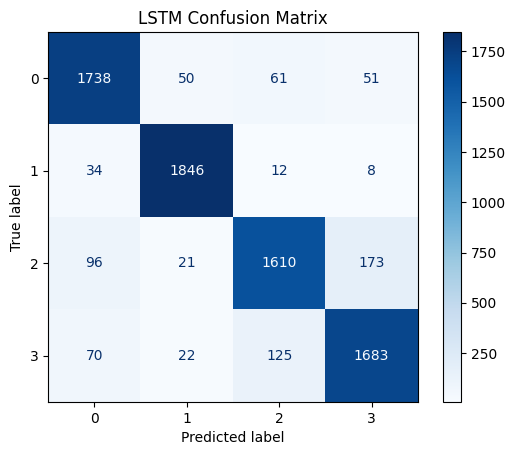

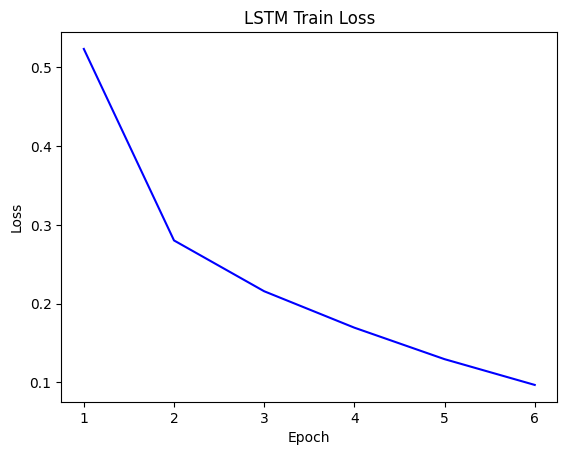

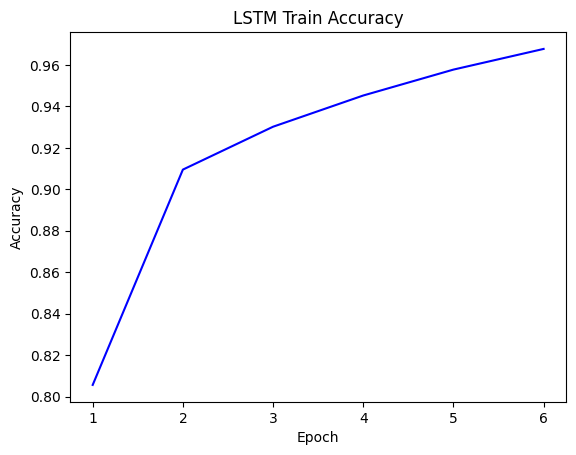

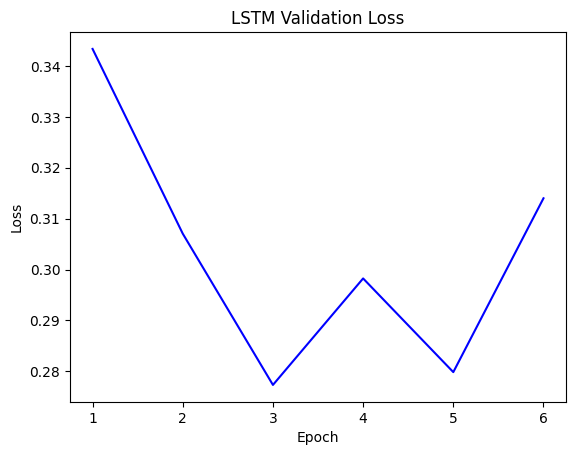

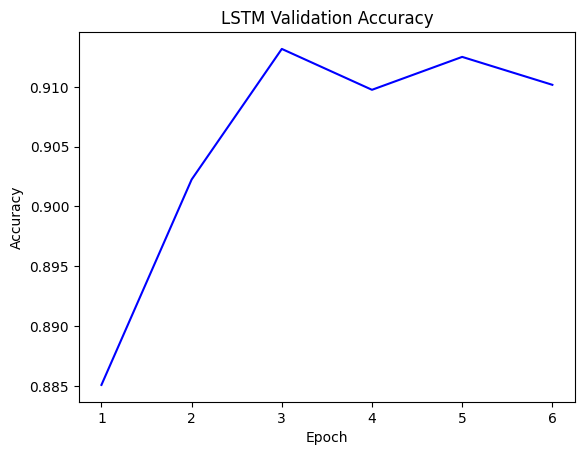

In [9]:
full_evaluation(lstm_model, lstm_history, test_loader, device, name="LSTM")